# Rapport Groupe 15

In [12]:
import os
from matplotlib import pyplot as plt
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'
import tensorflow.keras as keras
import numpy as np
import datetime
import platform
from ctypes import *
import tqdm
import json
from PIL import Image
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
import seaborn as sns
import pandas as pd

In [3]:
def get_lib():
    path_to_shared_library = "target/release/librust_lib.dylib"
    path_to_shared_library_windows = "target\\debug\\rust_lib.dll"

    if platform.system() == 'Windows':
        my_lib = cdll.LoadLibrary(path_to_shared_library_windows)
    else:
        my_lib = cdll.LoadLibrary(path_to_shared_library)
    return my_lib

In [4]:
def toList(arr):
    return [j for i in arr for j in i]

Le but de ce rapport est de démontrer les résultats que nous avons pu obtenir après 4 mois de travail. L'objectif de notre projet était de pouvoir déterminer le genre d'un film à partir de son affiche. Nous avons décidé de coder les différents algorithmes en Rust. 
La lecture de ce rapport permettra de voir comment certains de nos algorithmes fonctionnent comparé à ceux du framework Tensorflow ainsi que d'expliquer le raisonnement pour lequel nous avons choisi un algorithme plutôt que les autres pour notre application web. 

Afin de pouvoir faciliter la réalisation de nos graphiques et la lisibilité du code nous avons utilisé des classes que l'on appelle des wrapper. Ces wrappers vont nous permettre de pouvoir utiliser des métriques qui ont été implémenté dans la lib sklearn. Cela va nous permettre une meilleure représentation de nos résultats. 

In [5]:
class MySKLearnRBFRawWrapper:
    def __init__(self, centers, X, input_dim, gamma, alpha: float = 0.01, iteration_count: int = 1000):
        self.lib = get_lib()
        if not hasattr(X, 'shape'):
            X = np.array(X, dtype="object")
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        X = X.flatten()
        X = X.tolist()
        try:
            X = toList(X)
        except:
            pass
        inputs_type = c_float * len(X)
        self.lib.create_rbf_model.argtypes = [c_int, inputs_type, c_int, c_int, c_float]
        self.lib.create_rbf_model.restype = c_void_p
        self.model = self.lib.create_rbf_model(centers, inputs_type(*X), len(X), input_dim, gamma)
        self.alpha = alpha
        self.iteration_count = iteration_count
        self.input_dim = input_dim

    def lloyd(self, X):
        if not hasattr(X, 'shape'):
            X = np.array(X, dtype="object")
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        X = X.flatten()
        X = X.tolist()
        try:
            X = toList(X)
        except:
            pass
        x_type = c_float * len(X)
        self.lib.lloyd.argtypes = [c_void_p, x_type, c_int]
        self.lib.lloyd.restype = None
        self.lib.lloyd(self.model, x_type(*X), len(X))

    def fit(self, X, Y):
        if not hasattr(X, 'shape'):
            X = np.array(X, dtype="object")
        if not hasattr(Y, 'shape'):
            Y = np.array(Y)
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        if len(Y.shape) == 1:
            Y = np.expand_dims(Y, axis=0)
        X = X.flatten()
        X = X.tolist()
        try:
            X = toList(X)
        except:
            pass
        Y = Y.flatten()
        Y = Y.tolist()
        inputs_type = c_float * len(X)
        outputs_type = c_float * len(Y)
        inputs_native = inputs_type(*X)
        outputs_native = outputs_type(*Y)
        self.lib.train_rbf_model_classification.argtypes = [c_void_p, inputs_type, outputs_type, c_int, c_int, c_int,
                                                            c_float]
        self.lib.train_rbf_model_classification.restype = None
        self.lib.train_rbf_model_classification(self.model, inputs_native, outputs_native, len(X), len(Y),
                                                self.iteration_count, self.alpha)

    def predict(self, X):
        if not hasattr(X, 'shape'):
            X = np.array(X, dtype="object")
        results = []
        sample_inputs_type = c_float * self.input_dim
        self.lib.predict_rbf_model_classification.argtypes = [c_void_p, sample_inputs_type]
        self.lib.predict_rbf_model_classification.restype = c_float
        for x in X:
            results.append(
                self.lib.predict_rbf_model_classification(self.model, sample_inputs_type(*x)))
        return np.array(results)

    def save(self, filename):
        self.lib.save_rbf_model.argtypes = [c_void_p, c_char_p]
        self.lib.save_rbf_model.restype = None
        self.lib.save_rbf_model(self.model, filename.encode("utf-8"))

    def destroy(self):
        self.lib.destroy_rbf_model.argtypes = [c_void_p]
        self.lib.destroy_rbf_model.restype = None
        self.lib.destroy_rbf_model(self.model)

In [6]:
class MySKLearnMLPRawWrapper:
    def __init__(self, npl: [int], classification: bool = True, alpha: float = 0.01, iteration_count: int = 1000):
        self.lib = get_lib()
        arr_type = c_int * len(npl)
        self.lib.create_mlp_model.argtypes = [arr_type, c_int]
        self.lib.create_mlp_model.restype = c_void_p
        self.model = self.lib.create_mlp_model(arr_type(*npl), len(npl))
        self.classification = classification
        self.alpha = alpha
        self.iteration_count = iteration_count

    def fit(self, X, Y):
        if not hasattr(X, 'shape'):
            X = np.array(X, dtype="object")
        if not hasattr(Y, 'shape'):
            Y = np.array(Y, dtype="object")
        if len(X.shape) == 1:
            X = np.expand_dims(X, axis=0)
        if len(Y.shape) == 1:
            Y = np.expand_dims(Y, axis=0)
        X = X.flatten()
        X = X.tolist()
        try:
            X = toList(X)
        except:
            pass
        Y = Y.flatten()
        Y = Y.tolist()
        inputs_type = c_float * len(X)
        outputs_type = c_float * len(Y)
        inputs_native = inputs_type(*X)
        outputs_native = outputs_type(*Y)
        self.lib.train_classification_stochastic_backdrop_mlp_model.argtypes = [c_void_p, inputs_type, outputs_type,
                                                                                c_float, c_int, c_int, c_int]
        self.lib.train_classification_stochastic_backdrop_mlp_model.restype = None
        self.lib.train_classification_stochastic_backdrop_mlp_model(self.model, inputs_native,
                                                                    outputs_native, self.alpha,
                                                                    self.iteration_count, len(X),
                                                                    len(Y))
    def predict(self, X, input_dim, output_dim):
        if not hasattr(X, 'shape'):
            X = np.array(X, dtype="object")
        results = []
        sample_inputs_type = c_float * input_dim
        self.lib.predict_mlp_model_classification.argtypes = [c_void_p, sample_inputs_type, c_int]
        self.lib.predict_mlp_model_classification.restype = POINTER(c_float)
        for x in X:
            prediction = self.lib.predict_mlp_model_classification(self.model, sample_inputs_type(*x), input_dim)
            result = np.ctypeslib.as_array(prediction, (output_dim,))
            results.append(np.array(result))
        return np.array(results)

    def save(self, filename):
        self.lib.save_mlp_model.argtypes = [c_void_p, c_char_p]
        self.lib.save_mlp_model.restype = None
        self.lib.save_mlp_model(self.model, filename.encode("utf-8"))

    def destroy(self):
        self.lib.destroy_model.argtypes = [c_void_p]
        self.lib.destroy_model.restype = None
        self.lib.destroy_model(self.model)

## Comparaison du fonctionnement de notre librairie par rapport à Keras Tensorflow

Nous allons tout d'abord utiliser Keras afin de voir comment fonctionne le XOR avec le MLP avec Keras et avec notre algo

In [4]:
X_random = np.random.uniform(-1, 1.0, (100, 2))
Y_random = np.random.uniform(-1, 1.0, (100, 1))
test_dataset = [[x1/10, x2 / 10] for x1 in range(-10, 15,2) for x2 in range(-10,15,2)]
colors = ["blue" if output >= 0 else "red" for output in Y]
model = keras.models.Sequential()
model.add(keras.layers.Dense(2, activation=keras.activations.tanh, input_dim=X.shape[-1]))
model.add(keras.layers.Dense(1, activation=keras.activations.tanh))
model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01), loss=keras.losses.mse)
h = model.fit(X, Y, batch_size=1, epochs=1000)
run_losses = np.array(h.history['loss'])

Epoch 1/1000
4/4 [==============================] - 0s 1ms/step - loss: 1.2266
Epoch 2/1000
4/4 [==============================] - 0s 852us/step - loss: 1.2042
Epoch 3/1000
4/4 [==============================] - 0s 809us/step - loss: 1.1848
Epoch 4/1000
4/4 [==============================] - 0s 875us/step - loss: 1.1687
Epoch 5/1000
4/4 [==============================] - 0s 864us/step - loss: 1.1573
Epoch 6/1000
4/4 [==============================] - 0s 1ms/step - loss: 1.1460
Epoch 7/1000
4/4 [==============================] - 0s 1ms/step - loss: 1.1384
Epoch 8/1000
4/4 [==============================] - 0s 1ms/step - loss: 1.1317
Epoch 9/1000
4/4 [==============================] - 0s 1ms/step - loss: 1.1274
Epoch 10/1000
4/4 [==============================] - 0s 964us/step - loss: 1.1225
Epoch 11/1000
4/4 [==============================] - 0s 1ms/step - loss: 1.1157
Epoch 12/1000
4/4 [==============================] - 0s 1ms/step - loss: 1.1148
Epoch 13/1000
4/4 [====================

4/4 [==============================] - 0s 1ms/step - loss: 0.9944
Epoch 203/1000
4/4 [==============================] - 0s 845us/step - loss: 0.9934
Epoch 204/1000
4/4 [==============================] - 0s 893us/step - loss: 0.9917
Epoch 205/1000
4/4 [==============================] - 0s 910us/step - loss: 0.9920
Epoch 206/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.9905
Epoch 207/1000
4/4 [==============================] - 0s 987us/step - loss: 0.9903
Epoch 208/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.9900
Epoch 209/1000
4/4 [==============================] - 0s 920us/step - loss: 0.9893
Epoch 210/1000
4/4 [==============================] - 0s 918us/step - loss: 0.9883
Epoch 211/1000
4/4 [==============================] - 0s 962us/step - loss: 0.9872
Epoch 212/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.9865
Epoch 213/1000
4/4 [==============================] - 0s 914us/step - loss: 0.9846
Epoch 214/1000
4/4 [=======

4/4 [==============================] - 0s 1ms/step - loss: 0.4473
Epoch 403/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.4417
Epoch 404/1000
4/4 [==============================] - 0s 896us/step - loss: 0.4380
Epoch 405/1000
4/4 [==============================] - 0s 788us/step - loss: 0.4322
Epoch 406/1000
4/4 [==============================] - 0s 978us/step - loss: 0.4269
Epoch 407/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.4228
Epoch 408/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.4180
Epoch 409/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.4136
Epoch 410/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.4084
Epoch 411/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.4032
Epoch 412/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.3995
Epoch 413/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.3948
Epoch 414/1000
4/4 [=================

4/4 [==============================] - 0s 856us/step - loss: 0.0639
Epoch 603/1000
4/4 [==============================] - 0s 871us/step - loss: 0.0635
Epoch 604/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0631
Epoch 605/1000
4/4 [==============================] - 0s 884us/step - loss: 0.0627
Epoch 606/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0624
Epoch 607/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0620
Epoch 608/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0616
Epoch 609/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0612
Epoch 610/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0609
Epoch 611/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0605
Epoch 612/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0602
Epoch 613/1000
4/4 [==============================] - 0s 809us/step - loss: 0.0598
Epoch 614/1000
4/4 [===============

4/4 [==============================] - 0s 1ms/step - loss: 0.0381
Epoch 704/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0380
Epoch 705/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0378
Epoch 706/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0376
Epoch 707/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0375
Epoch 708/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0373
Epoch 709/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0372
Epoch 710/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0370
Epoch 711/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0369
Epoch 712/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0367
Epoch 713/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0366
Epoch 714/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0364
Epoch 715/1000
4/4 [=======================

4/4 [==============================] - 0s 2ms/step - loss: 0.0198
Epoch 906/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0197
Epoch 907/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0197
Epoch 908/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0196
Epoch 909/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0196
Epoch 910/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 911/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0195
Epoch 912/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 913/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0194
Epoch 914/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0193
Epoch 915/1000
4/4 [==============================] - 0s 2ms/step - loss: 0.0193
Epoch 916/1000
4/4 [==============================] - 0s 1ms/step - loss: 0.0193
Epoch 917/1000
4/4 [=======================

In [ ]:
plt.plot(run_losses)
plt.legend(['loss'], loc='upper left')
plt.title('Evolution of loss for MLP with Rust library')
plt.xlabel('epochs')
plt.ylabel('mean squared error')
plt.show()

Le code suivant permet de montrer l'exécution du XOR avec notre algorithme

100%|██████████| 1000/1000 [00:01<00:00, 723.98it/s]


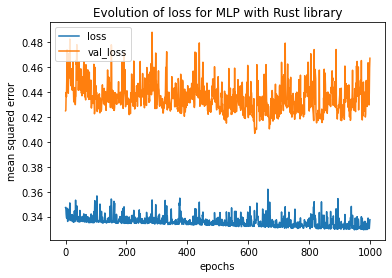

In [6]:
X_random = np.random.uniform(-1, 1.0, (100, 2))
Y_random = np.random.uniform(-1, 1.0, (100, 1))

val_X_random = np.random.uniform(-1, 1.0, (10, 2))
val_Y_random = np.random.uniform(-1, 1.0, (10, 1))
d=[2,3,1]

wrapped_model = MySKLearnMLPRawWrapper(d, iteration_count=len(X_random))
losses = []
val_losses = []
for epoch in tqdm.tqdm(range(1000)):
    wrapped_model.fit(X_random, Y_random)
    predicted_y_train=wrapped_model.predict(X_random, 2, 1)
    predicted_y_test=wrapped_model.predict(val_X_random, 2, 1)
    
    loss=mean_squared_error(Y_random, predicted_y_train)
    losses.append(loss)
    
    val_loss = mean_squared_error(val_Y_random, predicted_y_test)
    val_losses.append(val_loss)

plt.plot(losses)
plt.plot(val_losses)
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.title('Evolution of loss for MLP with Rust library')
plt.xlabel('epochs')
plt.ylabel('mean squared error')
plt.show()

## Tests sur les cas de tests

Les cas de tests on été pour nous un moyen intéressant de voir les différentes façon dont fonctionne les différents algorithmes que nous avons implémenté. Dans le cas du modèle linéaire il ne fonctionnait pas sur le cas du XOR mais nous avons pu remarquer que les points n'étaient pas séparés de la même façon quand on le traitait avec le MLP ou le RBF

100%|██████████| 1000/1000 [00:00<00:00, 1806.55it/s]


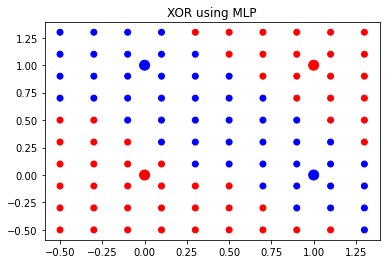

[]

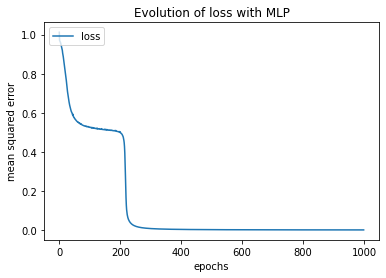

In [7]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1])
colors = ["blue" if output >= 0 else "red" for output in Y]
d=[2,2,1]

wrapped_model = MySKLearnMLPRawWrapper(d, alpha=0.001,iteration_count=1000)
losses = []
for epoch in tqdm.tqdm(range(1000)):
    wrapped_model.fit(X, Y)
    predicted_y_train=wrapped_model.predict(X, 2, 1)
    loss=mean_squared_error(Y, predicted_y_train)
    losses.append(loss)

test_dataset = [[x1/10, x2 / 10] for x1 in range(-5, 15,2) for x2 in range(-5,15,2)]
predicted_outputs = wrapped_model.predict(test_dataset, 2, 1)
predicted_outputs_colors = ['blue' if label >= 0.0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=100)
plt.title('XOR using MLP')
plt.show()

plt.plot(losses)
plt.legend(['loss'], loc='upper left')
plt.title('Evolution of loss with MLP')
plt.xlabel('epochs')
plt.ylabel('mean squared error')
plt.plot()

100%|██████████| 1000/1000 [00:00<00:00, 2723.04it/s]


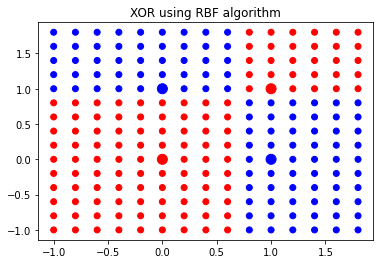

[]

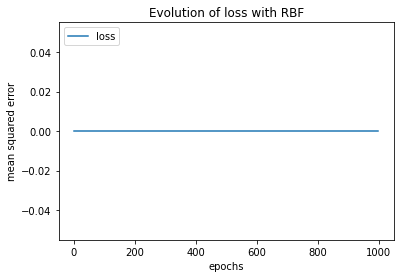

In [8]:
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]])
Y = np.array([1, 1, -1, -1])
colors = ["blue" if output >= 0 else "red" for output in Y]

wrapped_model = MySKLearnRBFRawWrapper(4, X, 2, 1, iteration_count=1000)
wrapped_model.lloyd(X)
losses = []
for epoch in tqdm.tqdm(range(1000)):
    wrapped_model.fit(X, Y)
    predicted_y_train=wrapped_model.predict(X)
    loss=mean_squared_error(Y, predicted_y_train)
    losses.append(loss)
    
test_dataset = [[x1/10, x2 / 10] for x1 in range(-10, 20,2) for x2 in range(-10,20,2)]
predicted_outputs = wrapped_model.predict(test_dataset)
predicted_outputs_colors = ['blue' if label >= 0.0 else 'red' for label in predicted_outputs]
plt.scatter([p[0] for p in test_dataset], [p[1] for p in test_dataset], c=predicted_outputs_colors)
plt.scatter([p[0] for p in X], [p[1] for p in X], c=colors, s=100)
plt.title('XOR using RBF algorithm')
plt.show()

plt.plot(losses)
plt.legend(['loss'], loc='upper left')
plt.title('Evolution of loss with RBF')
plt.xlabel('epochs')
plt.ylabel('mean squared error')
plt.plot()

## Application à notre dataset

In [7]:
def import_dataset(file_path):
    with open(file_path) as json_file:
        dataset = json.load(json_file)
    return dataset

def get_pixels(image):
    image = Image.open(image)
    image = image.resize((8, 8))
    im_arr = np.array(image).flatten()
    return np.array(im_arr) / 255.0

In [8]:
train_dataset = import_dataset('nouveau_dataset/train_dataset.json')
test_dataset = import_dataset('nouveau_dataset/test_dataset.json')
x_train = []
x_test = []
y_train = []
y_test = []

for image in train_dataset:
    x_train.append(get_pixels(image['image']))
    y_train.append(image['genre'])
for image in test_dataset:
    x_test.append(get_pixels(image['image']))
    y_test.append(image['genre'])
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)
sample_inputs_len = len(x_train[0])
y_train_action = y_train[:, 1]
y_train_comedy = y_train[:, 2]
y_train_horror = y_train[:, 0]

inputs_len = len(x_train)
outputs_len = len(y_train_horror)
output_dim = 1

In [9]:
wrapped_model_action = MySKLearnRBFRawWrapper(50, x_train, sample_inputs_len, 1.1, iteration_count=len(x_train))
wrapped_model_comedy = MySKLearnRBFRawWrapper(50, x_train, sample_inputs_len, 1.1, iteration_count=len(x_train))
wrapped_model_horror = MySKLearnRBFRawWrapper(50, x_train, sample_inputs_len, 1.1, iteration_count=len(x_train))
losses = []
val_losses = []
accs = []
val_accs = []
wrapped_model_action.lloyd(x_train)
wrapped_model_comedy.lloyd(x_train)
wrapped_model_horror.lloyd(x_train)
for epoch in tqdm.tqdm(range(1000)):
    wrapped_model_action.fit(x_train, y_train_action)
    wrapped_model_comedy.fit(x_train, y_train_comedy)
    wrapped_model_horror.fit(x_train, y_train_horror)

    predicted_y_train_action = wrapped_model_action.predict(x_train)
    predicted_y_train_comedy = wrapped_model_comedy.predict(x_train)
    predicted_y_train_horror = wrapped_model_horror.predict(x_train)
    predicted_y_train = []
    for i in range(0, len(predicted_y_train_horror)):
        predicted_y_train.append([predicted_y_train_horror[i], predicted_y_train_action[i], predicted_y_train_comedy[i]])

    predicted_y_test_action = wrapped_model_action.predict(x_test)

    predicted_y_test_comedy = wrapped_model_comedy.predict(x_test)
    predicted_y_test_horror = wrapped_model_horror.predict(x_test)
    predicted_y_test = []

    for i in range(0, len(predicted_y_test_horror)):
        predicted_y_test.append([predicted_y_test_horror[i], predicted_y_test_action[i], predicted_y_test_comedy[i]])

    loss = mean_squared_error(y_train, predicted_y_train)
    losses.append(loss)
    val_loss = mean_squared_error(y_test, predicted_y_test)
    val_losses.append(val_loss)

    acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(predicted_y_train, axis=1))
    accs.append(acc)
    val_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
    val_accs.append(val_acc)

100%|██████████| 1000/1000 [16:17<00:00,  1.02it/s]


The validation accuracy is 0.4785714285714286


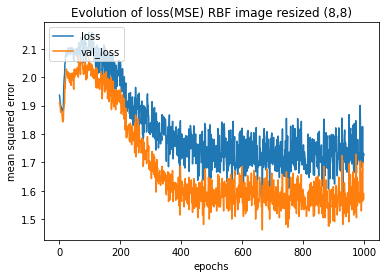

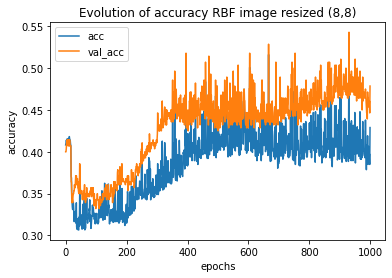

In [10]:
print(f"The validation accuracy is {val_acc}")
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.title('Evolution of loss(MSE) RBF image resized (8,8)')
plt.xlabel('epochs')
plt.ylabel(f'mean squared error')
plt.show()

plt.plot(accs)
plt.plot(val_accs)
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.title('Evolution of accuracy RBF image resized (8,8)')
plt.xlabel('epochs')
plt.ylabel(f'accuracy')
plt.show()

<AxesSubplot:>

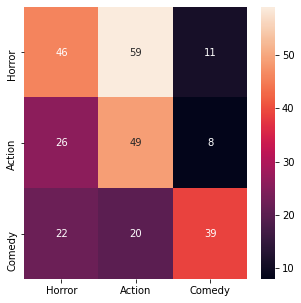

In [14]:
predicted_y_test_action = wrapped_model_action.predict(x_test)
predicted_y_test_comedy = wrapped_model_comedy.predict(x_test)
predicted_y_test_horror = wrapped_model_horror.predict(x_test)
predicted_y_test = []
for i in range(0, len(predicted_y_test_horror)):
    predicted_y_test.append([predicted_y_test_horror[i], predicted_y_test_action[i], predicted_y_test_comedy[i]])
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
df_cm = pd.DataFrame(matrix, index=[i for i in ["Horror", "Action", "Comedy"]], columns = [i for i in ["Horror", "Action", "Comedy"]])
plt.figure(figsize=(5,5))
sns.heatmap(df_cm, annot=True)

In [15]:
#destroy
wrapped_model_action.destroy()
wrapped_model_comedy.destroy()
wrapped_model_horror.destroy()

In [16]:
train_dataset = import_dataset('nouveau_dataset/train_dataset.json')
test_dataset = import_dataset('nouveau_dataset/test_dataset.json')
x_train = []
x_test = []
y_train = []
y_test = []

for image in train_dataset:
    x_train.append(get_pixels(image['image']))
    y_train.append(image['genre'])
for image in test_dataset:
    x_test.append(get_pixels(image['image']))
    y_test.append(image['genre'])
y_train = np.array(y_train)
y_test = np.array(y_test)
#y_train = [[i[0], i[2]] for i in y_train]
#y_test = [[i[0], i[2]] for i in y_test]

In [17]:
sample_inputs_len = len(x_train[0])
d = [sample_inputs_len, 2]
losses = []
val_losses = []
accs = []
val_accs = []
wrapped_model = MySKLearnMLPRawWrapper(d, alpha=0.1,iteration_count=len(x_train))
for epoch in tqdm.tqdm(range(1000)):
    wrapped_model.fit(x_train, y_train)
    predicted_y_train = wrapped_model.predict(x_train, sample_inputs_len, 3)
    predicted_y_test = wrapped_model.predict(x_test, sample_inputs_len, 3)

    loss = mean_squared_error(y_train, predicted_y_train)
    losses.append(loss)
    val_loss = mean_squared_error(y_test, predicted_y_test)
    val_losses.append(val_loss)

    acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(predicted_y_train, axis=1))
    accs.append(acc)
    val_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
    val_accs.append(val_acc)

100%|██████████| 1000/1000 [02:12<00:00,  7.57it/s]


0.325


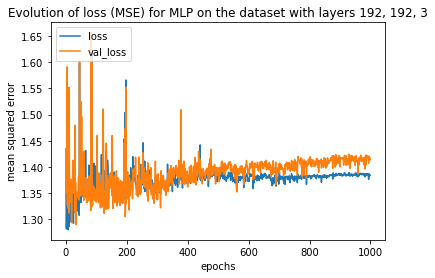

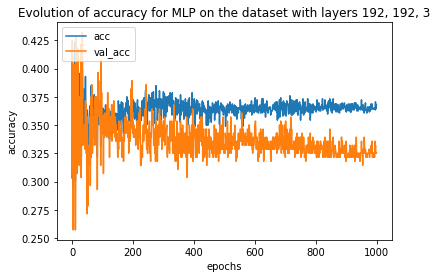

In [18]:
print(val_accs[-1])
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.title('Evolution of loss (MSE) for MLP on the dataset with layers 192, 192, 3')
plt.xlabel('epochs')
plt.ylabel(f'mean squared error')
plt.show()

plt.plot(accs)
plt.plot(val_accs)
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.title('Evolution of accuracy for MLP on the dataset with layers 192, 192, 3')
plt.xlabel('epochs')
plt.ylabel(f'accuracy')
plt.show()

<AxesSubplot:>

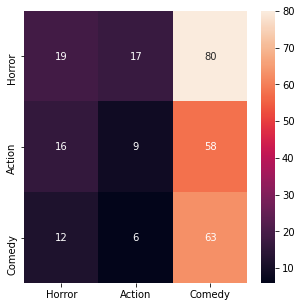

In [21]:
predicted_y_test = wrapped_model.predict(x_test, sample_inputs_len, 3)
confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
df_cm = pd.DataFrame(matrix, index=[i for i in ["Horror", "Action", "Comedy"]], columns = [i for i in ["Horror", "Action", "Comedy"]])
plt.figure(figsize=(5,5))
sns.heatmap(df_cm, annot=True)

In [22]:
#destroy
wrapped_model.destroy()

In [23]:
train_dataset = import_dataset('nouveau_dataset/train_dataset.json')
test_dataset = import_dataset('nouveau_dataset/test_dataset.json')
x_train = []
x_test = []
y_train = []
y_test = []

for image in train_dataset:
    x_train.append(get_pixels(image['image']))
    y_train.append(image['genre'])
for image in test_dataset:
    x_test.append(get_pixels(image['image']))
    y_test.append(image['genre'])
y_train = np.array(y_train).astype(np.float32)
y_test = np.array(y_test).astype(np.float32)
sample_inputs_len = len(x_train[0])
y_train_comedy = y_train[:, 2]
y_train_horror = y_train[:, 0]
y_train = [[i[0], i[2]] for i in y_train]
y_test = [[i[0], i[2]] for i in y_test]

In [24]:
inputs_len = len(x_train)
outputs_len = len(y_train_horror)
output_dim = 1
wrapped_model_comedy = MySKLearnRBFRawWrapper(50, x_train, sample_inputs_len, 1.1, iteration_count=len(x_train))
wrapped_model_horror = MySKLearnRBFRawWrapper(50, x_train, sample_inputs_len, 1.1, iteration_count=len(x_train))
losses = []
val_losses = []
accs = []
val_accs = []
wrapped_model_comedy.lloyd(x_train)
wrapped_model_horror.lloyd(x_train)
for epoch in tqdm.tqdm(range(1000)):
    wrapped_model_comedy.fit(x_train, y_train_comedy)
    wrapped_model_horror.fit(x_train, y_train_horror)

    predicted_y_train_comedy = wrapped_model_comedy.predict(x_train)
    predicted_y_train_horror = wrapped_model_horror.predict(x_train)
    predicted_y_train = []
    for i in range(0, len(predicted_y_train_horror)):
        predicted_y_train.append([predicted_y_train_horror[i], predicted_y_train_comedy[i]])


    predicted_y_test_comedy = wrapped_model_comedy.predict(x_test)
    predicted_y_test_horror = wrapped_model_horror.predict(x_test)
    predicted_y_test = []

    for i in range(0, len(predicted_y_test_horror)):
        predicted_y_test.append([predicted_y_test_horror[i], predicted_y_test_comedy[i]])

    loss = mean_squared_error(y_train, predicted_y_train)
    losses.append(loss)
    val_loss = mean_squared_error(y_test, predicted_y_test)
    val_losses.append(val_loss)

    acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(predicted_y_train, axis=1))
    accs.append(acc)
    val_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
    val_accs.append(val_acc)

100%|██████████| 1000/1000 [11:50<00:00,  1.41it/s]


The validation accuracy of the RBF with two classes is 0.6642857142857143


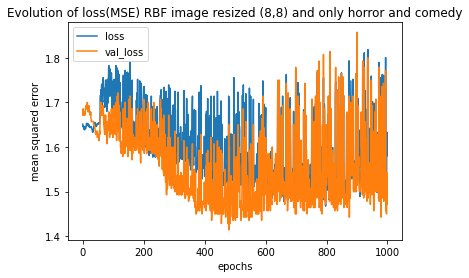

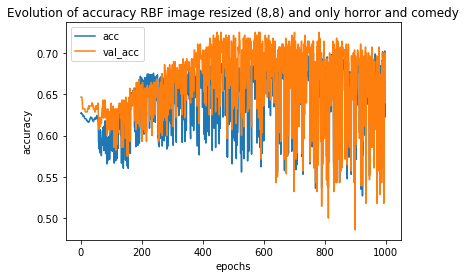

In [25]:
print(f"The validation accuracy of the RBF with two classes is {val_accs[-1]}")
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.title('Evolution of loss(MSE) RBF image resized (8,8) and only horror and comedy')
plt.xlabel('epochs')
plt.ylabel(f'mean squared error')
plt.show()

plt.plot(accs)
plt.plot(val_accs)
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.title('Evolution of accuracy RBF image resized (8,8) and only horror and comedy')
plt.xlabel('epochs')
plt.ylabel(f'accuracy')
plt.show()

<AxesSubplot:>

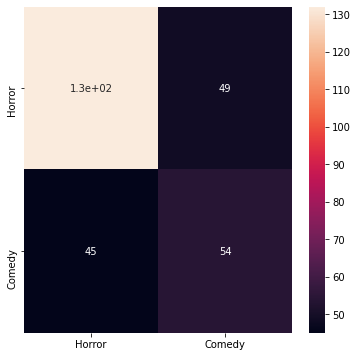

In [27]:
predicted_y_test_comedy = wrapped_model_comedy.predict(x_test)
predicted_y_test_horror = wrapped_model_horror.predict(x_test)
predicted_y_test = []
for i in range(0, len(predicted_y_test_horror)):
    predicted_y_test.append([predicted_y_test_horror[i], predicted_y_test_comedy[i]])
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
df_cm = pd.DataFrame(matrix, index=[i for i in ["Horror", "Comedy"]], columns = [i for i in ["Horror", "Comedy"]])
plt.figure(figsize=(6,6))
sns.heatmap(df_cm, annot=True)

In [28]:
#destroy
wrapped_model_comedy.destroy()
wrapped_model_horror.destroy()

In [29]:
train_dataset = import_dataset('nouveau_dataset/train_dataset.json')
test_dataset = import_dataset('nouveau_dataset/test_dataset.json')
x_train = []
x_test = []
y_train = []
y_test = []

for image in train_dataset:
    x_train.append(get_pixels(image['image']))
    y_train.append(image['genre'])
for image in test_dataset:
    x_test.append(get_pixels(image['image']))
    y_test.append(image['genre'])
y_train = np.array(y_train)
y_test = np.array(y_test)
y_train = [[i[0], i[2]] for i in y_train]
y_test = [[i[0], i[2]] for i in y_test]

In [30]:
sample_inputs_len = len(x_train[0])
d = [sample_inputs_len, 2]
losses = []
val_losses = []
accs = []
val_accs = []
wrapped_model = MySKLearnMLPRawWrapper(d, alpha=0.1,iteration_count=len(x_train))
for epoch in tqdm.tqdm(range(1000)):
    wrapped_model.fit(x_train, y_train)
    predicted_y_train = wrapped_model.predict(x_train, sample_inputs_len, 2)
    predicted_y_test = wrapped_model.predict(x_test, sample_inputs_len, 2)

    loss = mean_squared_error(y_train, predicted_y_train)
    losses.append(loss)
    val_loss = mean_squared_error(y_test, predicted_y_test)
    val_losses.append(val_loss)

    acc = accuracy_score(np.argmax(y_train, axis=1), np.argmax(predicted_y_train, axis=1))
    accs.append(acc)
    val_acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
    val_accs.append(val_acc)

100%|██████████| 1000/1000 [02:06<00:00,  7.91it/s]


The validation accuracy of the RBF with two classes is 0.675


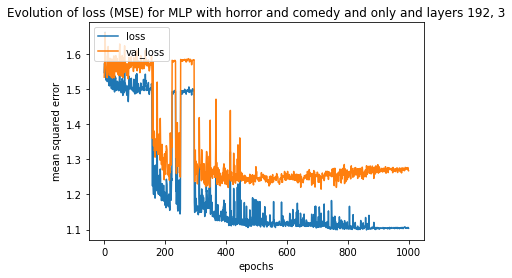

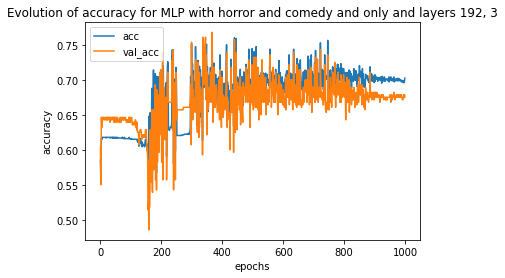

In [31]:
print(f"The validation accuracy of the RBF with two classes is {val_accs[-1]}")
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['loss', 'val_loss'], loc='upper left')
plt.title('Evolution of loss (MSE) for MLP with horror and comedy and only and layers 192, 3')
plt.xlabel('epochs')
plt.ylabel(f'mean squared error')
plt.show()

plt.plot(accs)
plt.plot(val_accs)
plt.legend(['acc', 'val_acc'], loc='upper left')
plt.title('Evolution of accuracy for MLP with horror and comedy and only and layers 192, 3')
plt.xlabel('epochs')
plt.ylabel(f'accuracy')
plt.show()

<AxesSubplot:>

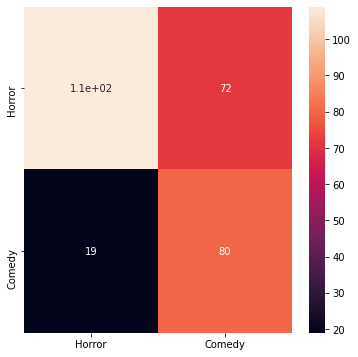

In [32]:
predicted_y_test = wrapped_model.predict(x_test, sample_inputs_len, 2)
confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predicted_y_test, axis=1))
df_cm = pd.DataFrame(matrix, index=[i for i in ["Horror", "Comedy"]], columns = [i for i in ["Horror", "Comedy"]])
plt.figure(figsize=(6,6))
sns.heatmap(df_cm, annot=True)

In [33]:
#destroy
wrapped_model.destroy()